# Mini Project 2

## By Thiyaghessan

#### In this project I understand how extremist conspiracy theories have evolved online via a text analysis of InfoWars content. The project includes the following steps:

1. Install Packages
2. Load text data
3. Clean Text Data
4. Select Topic Model with highest coherence
5. Create Dynamic Topic Models and compare results

My models have been saved
 - in a folder entitled topic_models
     - lda.model.state : initial lda topic model with 10 topics
      - This has other lda files used to load the topic model
     - dtm.model : initial dtm with 10 topics
     - dtmsubset.model :dtm on a subset of articles with 5 topics
 - pyLDAvis visuals have been saved in a folder called visuals
 
 Additional files
  - json files with scraped pages in a folder
  - a csv file with tokens and their frequencies
  - mp2scraper which I used to scrape the webpages
  - word document with project description

### Install Packages

In [39]:
import json
import matplotlib.pyplot as plt
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
from gensim import corpora, models
from gensim.utils import effective_n_jobs
import nltk
from nltk.stem.snowball import SnowballStemmer
from tqdm.auto import tqdm
# register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`
tqdm.pandas()

from collections import Counter 

from gensim.models import LdaSeqModel
from ipywidgets import interact
from gensim.models.coherencemodel import CoherenceModel

In [40]:
def read_json(data):
    '''
    Reads a json file and carefully indexes it
    
    Input:
        data (json): A json file
    Output:
        df (dataframe): A pandas data frame    
    '''
    with open(data, 'r') as file:
        infowars_data = json.load(file)


    df = pd.read_json(infowars_data, convert_axes = False)
    df = df.transpose()
    df.index.name = "Date-Time"
    Date = []
    
    for row in df.index:
        date = row[0:8]
        Date.append(date)

    df["Date"] = Date
    df["Date"] = df["Date"].astype(int)
    df['Date']= pd.to_datetime(df['Date'], format = "%Y%m%d")
    
    return df

## Prepare text files for analysis

### Article Text     

#### Preprocessing scraped pages

I do a few things:

 - remove "\n" characters
 - remove authors and dates since they are irrelevant to the articles' contents
 - create new dataframes without unnecessary columns

In [41]:
def article_converter(json, year):
    '''
    Converts my json file into a suitable format for text analysis
    '''
    df = read_json(json)
    unique_articles = set()
    
    for row in df['contents']:
        for string in row:
            string = string.replace("\n", "")
            index = string.find(str(year))
            string = string[index+4:]
            unique_articles.add(string)
            
    unique_articles = list(unique_articles)    
    df_formatted = pd.DataFrame(unique_articles, columns=["contents"])
    df_formatted['year'] = year
    return df_formatted

Combine all my processed json files into a single dataframe

In [42]:
articles_nov08 = article_converter('scraped_pages/obama_scraped_pages_nov08_cleaned.json', 2008)
articles_nov09 = article_converter('scraped_pages/obama_scraped_pages_nov09_cleaned.json', 2009)
articles_nov10 = article_converter('scraped_pages/obama_scraped_pages_nov10_cleaned.json', 2010)
articles_nov11 = article_converter('scraped_pages/obama_scraped_pages_nov11_cleaned.json', 2011)
articles_nov12 = article_converter('scraped_pages/obama_scraped_pages_nov12_cleaned.json', 2012)
all_articles = pd.concat([articles_nov08, articles_nov09, articles_nov10, articles_nov11, articles_nov12])

By looking at the dataframe itself, I can see that I have 1900 articles to work with

In [43]:
all_articles

,contents,year
0,This just in on the ongoing ID Card issue. (BT...,2008
1,Hillary Clinton is a popular choice for Secret...,2008
2,"Despite being quiet and respectful, Stewart’s ...",2008
3,"As the US public is dimly aware, things are no...",2008
4,"TorontoChange.com, a local chapter of the We A...",2008
...,...,...
40,The 13-inch android is scheduled to be complet...,2012
41,Indianapolis writer and editor Corey Michael D...,2012
42,The Pentagon’s spy agency is to be reformed in...,2012
43,Rhode Island today became the first state in t...,2012


#### Here I code in all my required helper functions

In [44]:
infowars_regex = "[^a-z\s]|swp no"
custom_stopwords = ["guardian", "eq", "addthis", "lou", "dobbs", 'html', "ha", "jon", "stewart", "geraldo", "h", \
                    "youtube", "similar", "related", "articles", "u", "th", "ajs", "scr", "https", "november", "reply", \
                    "says", "document", "pm", "people", "like", "would", "one", "write", "get", "know", "time", "think", \
                    "used", "see", "even", "right", "said", "amp", "st", "http", "nd", "e", "r", "www", "rd", "v", "var", \
                    "n", "php", "fo", "mmm", "ajs", "ipt", "scr", "https", "called", "show", "alex", "jones", "TRUE", "etc", \
                    "mr", "FALSE", "c", "cdata", "co", "b", "p", "f", "cb", "loc", "username", "ruleslogin", "registerlost", \
                    "na", "x", "pmthe", "gon", "ok", "g", "w", "get", "go", "many", "way", "could", "say", "com", \
                    "web", "org", "infowars", "context", "max", "also", "go", "going", "need", "many", "take", "need", \
                    "white", "want", "news", "something", "back", "tip", "pay", "december", "march", "january", \
                    "february", "april", "may", "june", "july", "august", "september", "october", 'man', 'truth', \
                    'come', 'real', 'really', 'believe', 'life', 'never', 'shall', 'let', 'watch', 'years', \
                    'every', 'much', 'look', 'day', 'country', 'nothing', 'first', 'real', 'never', 'much', \
                    'still', 'years', 'nothing', 'thing', 'come', 'country', 'let', 'got', 'look', 'anything', \
                    'maybe', 'video', 'really', 'use', 'never', 'every', "comment", "password", "location", "god", \
                    "america", "american", "read", "food", "charset"]

def tokenize_infowars(text_series, stopwords=[]):
    '''
    Cleans + tokenizes Pandas series of strings from the Salem Witch dataset.
    
    Returns pandas series of lists of tokens
    '''
    clean = text_series.str.lower() \
                       .str.replace(infowars_regex,
                                    " ",
                                    regex=True)

    stop = nltk.corpus.stopwords.words('english') + stopwords + custom_stopwords

    tokenize = lambda text: [i for i in nltk.word_tokenize(text) if i not in stop]
    stemmer = lambda tokens: [SnowballStemmer('english').stem(token) for token in tokens]
    
    tokens = clean.apply(tokenize)
    stemmed_tokens = tokens.apply(stemmer)
    
    return tokens

def prepare_data(tokens):
    '''
    Prepares Pandas series of lists of tokens for use within a Gensim topic model
    
    Returns an id2word dictionary + bag of words corpus
    '''
    # Initialize Series of tokens as Gensim Dictionary for further processing
    dictionary = corpora.Dictionary([i for i in tokens])

    # Convert dictionary into bag of words format: list of (token_id, token_count) tuples
    bow_corpus = [dictionary.doc2bow(text) for text in tokens]
    
    return dictionary, bow_corpus

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    '''
    Computes Coherence values for LDA models with differing numbers of topics.
    
    Returns list of models along with their respective coherence values (pick
    models with the highest coherence)
    '''
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.ldamulticore.LdaMulticore(corpus=corpus,
                                                 id2word=dictionary,
                                                 num_topics=num_topics,
                                                 workers=effective_n_jobs(-1),
                                                 passes=20,
                                                 iterations=400)
        model_list.append(model)
        coherence_model = models.coherencemodel.CoherenceModel(model=model, 
                                                               corpus=corpus,
                                                               dictionary=dictionary,
                                                               coherence='u_mass')
        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values

def fill_topic_weights(df_row, bow_corpus, ldamodel):
    '''
    Fill DataFrame rows with topic weights for topics in texts.
    
    Modifies DataFrame rows *in place*.
    '''
    try:
        for i in ldamodel[bow_corpus[df_row.name]]:
            df_row[str(i[0])] = i[1]
    except:
        return df_row
    return df_row

def unique_headlines(df, year):
        
    df['titlestring'] = [','.join(map(str, l)) for l in df['titles']]

    unique_headlines = set()

    for row in df['titles']:
        for lst in row:
            unique_headlines.add(lst)

    unique_headlines = list(unique_headlines)

    new_df = pd.DataFrame(unique_headlines, columns=['titles'])
    new_df['year'] = year
    
    return new_df

def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].apply(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

## DTM Functions

def print_dtm(dtm, n_topics, n_time_slices):
    '''
    Prints out top words in each topic across time slices for visual comparison
    
    Input: Gensim LdaSeqModel, n_topics (int), n_time_slices (int)
    '''
    for topic in range(n_topics):
        for time in range(n_time_slices): 
            print("##### Topic {}, Time Slice {} #####".format(topic, time))    
            print(dtm.dtm_coherence(time)[topic][:10])    
        print("\n")

def dtm_coherence(list_dtms, bow_corpus, dictionary, n_time_slices):
    '''
    Computes UMass Coherence for each time slice in a list of DTMs
    
    Input: List of Gensim LdaSeqModels, number of time slices modeled (int)
    Returns: Dict of lists of coherence scores for each DTM
    '''
    coherence = {}
    for i, ldaseq in enumerate(list_dtms):
        coherence[i] = []
        for t in range(n_time_slices):
            topics_dtm = ldaseq.dtm_coherence(t)
            cm_DTM = CoherenceModel(topics=topics_dtm,
                                    corpus=bow_corpus,
                                    dictionary=dictionary,
                                    coherence='u_mass')

            coherence[i].append(cm_DTM.get_coherence())
            
        return coherence

<>:1: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
<ipython-input-44-69334049b0cc>:1: DeprecationWarning: invalid escape sequence \s
  infowars_regex = "[^a-z\s]|swp no"


### Explore the text data

#### Get a frequency list and distribution to determine the stopwords to remove

In [45]:
all_articles['tokens'] = tokenize_infowars(all_articles['contents'])
freq_articles = count_words(all_articles)
freq_articles

,freq
token,
us,10284
government,7168
world,6570
new,5216
war,4775
...,...
obamadear,2
enemie,2
greenea,2


In [46]:
freq_articles

,freq
token,
us,10284
government,7168
world,6570
new,5216
war,4775
...,...
obamadear,2
enemie,2
greenea,2


In [91]:
freq_articles.to_csv("freq.csv")

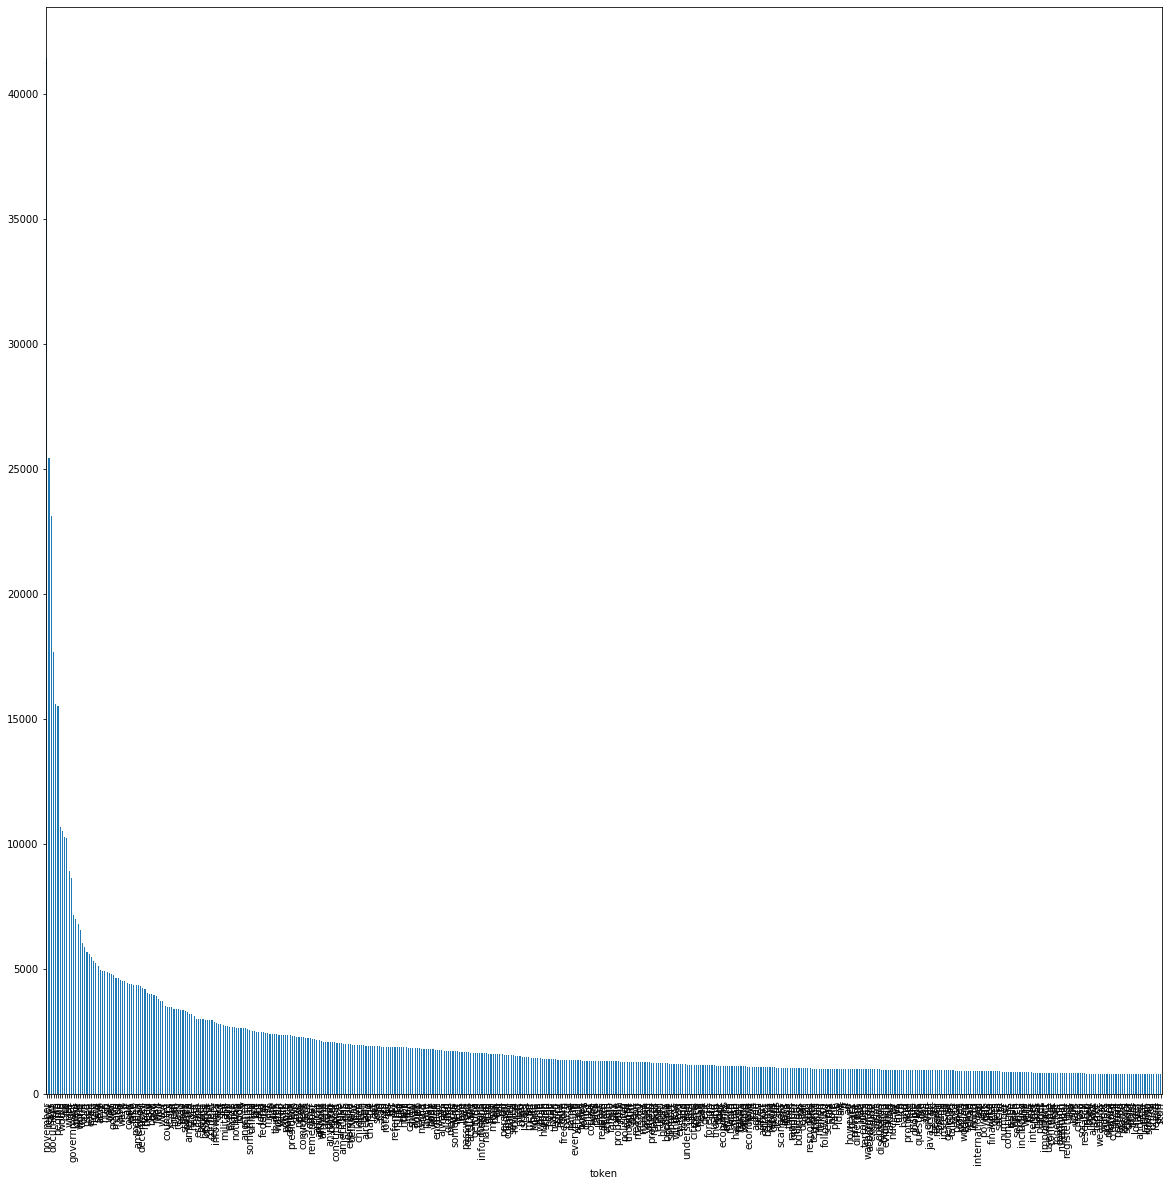

In [92]:
freq_graph = freq_articles['freq'].head(500)
freq_graph.plot(kind='bar', rot=90, figsize=(20, 20))

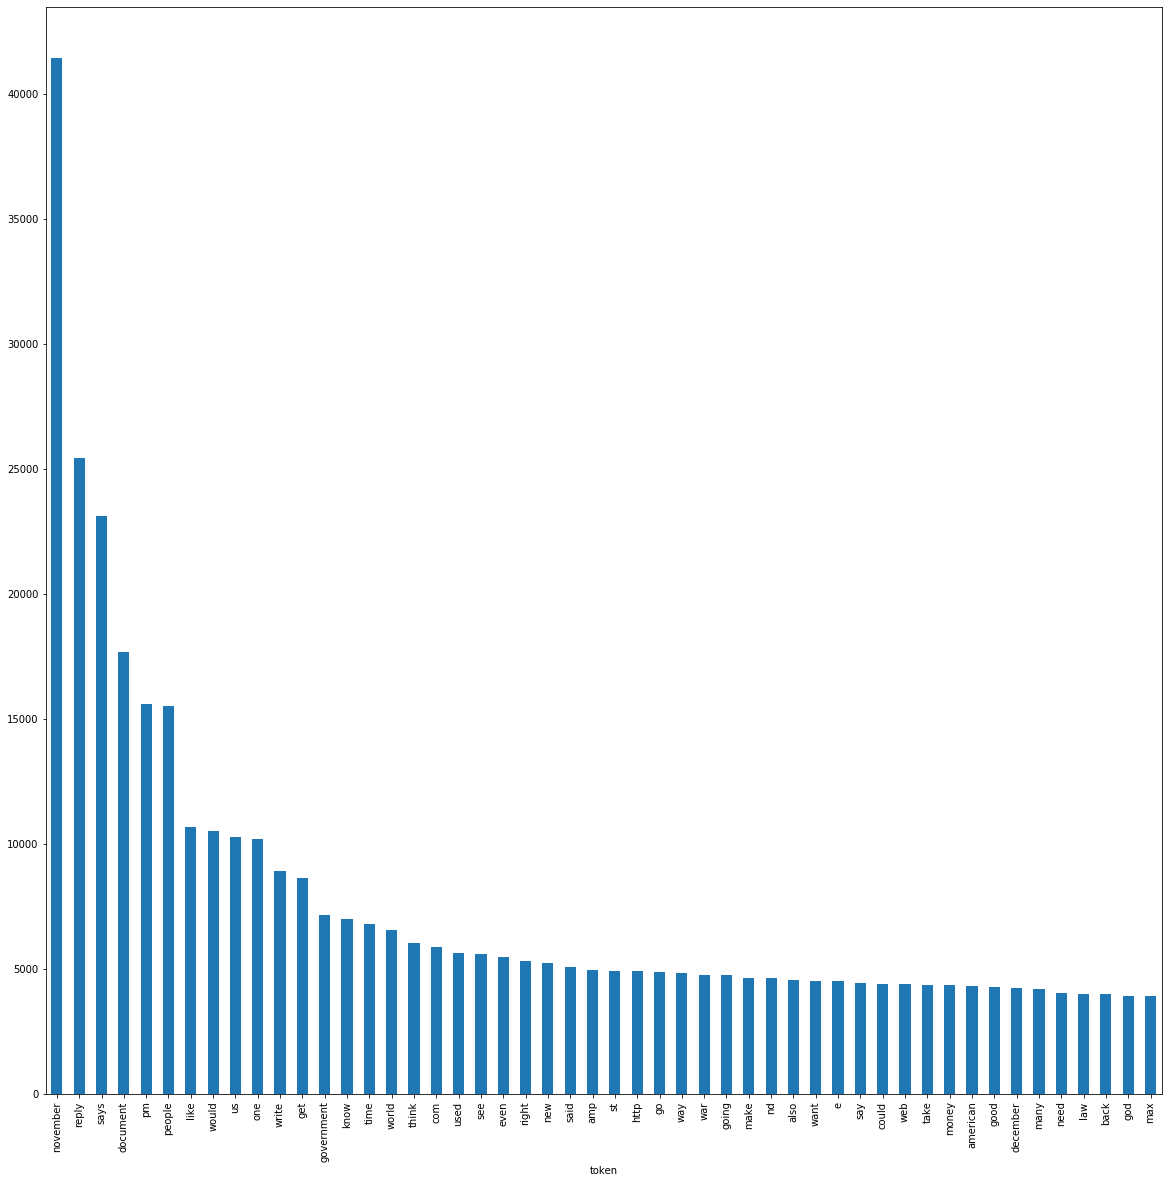

In [96]:
freq_graph = freq_articles['freq'].head(50)
freq_graph.plot(kind='bar', rot=90, figsize=(20, 20))

There are 46964 words, I remove the 40 most common words

In [47]:
infowars_stopwords = list(freq_articles['freq'].keys()[0:41])

I then recreate my list of tokens

In [48]:
all_articles['tokens'] = tokenize_infowars(all_articles['contents'], infowars_stopwords)

### Now, I create a list of models and calculate their coherence scores

In [49]:
dictionary, bow_corpus = prepare_data(all_articles['tokens'])

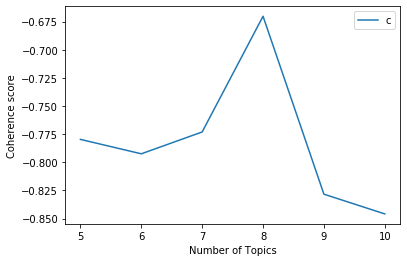

In [50]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary,
                                                           corpus=bow_corpus,
                                                           texts=all_articles['tokens'],
                                                           start=5,
                                                           limit=11,
                                                           step=1)
plt.plot(range(5, 11, 1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

### I then identify model with the highest coherence score and print out/visualize the topic consituents.

In [51]:
ldamodel = model_list[5]

for i, topic in ldamodel.show_topics(formatted=False, num_words=10):
    print('Topic {}: \n{}'.format(i, [w[0] for w in topic]))

Topic 0: 
['iran', 'israel', 'nuclear', 'korea', 'missile', 'israeli', 'attack', 'north', 'china', 'weapons']
Topic 1: 
['flu', 'vaccine', 'wall', 'swine', 'vaccines', 'street', 'occupy', 'debt', 'jesse', 'virus']
Topic 2: 
['flag', 'constitution', 'act', 'congress', 'enemy', 'rights', 'powers', 'means', 'land', 'national']
Topic 3: 
['body', 'scanners', 'airport', 'fly', 'global', 'media', 'change', 'plane', 'information', 'archive']
Topic 4: 
['gold', 'job', 'silver', 'always', 'little', 'better', 'tell', 'anyone', 'bad', 'someone']
Topic 5: 
['water', 'fluoride', 'health', 'vote', 'court', 'internet', 'cancer', 'supreme', 'case', 'year']
Topic 6: 
['delivery', 'referrer', 'rotate', 'al', 'iraq', 'archive', 'math', 'afghanistan', 'iran', 'cia']
Topic 7: 
['cia', 'math', 'archive', 'referrer', 'rotate', 'delivery', 'iran', 'uk', 'wtc', 'children']
Topic 8: 
['fed', 'reserve', 'paul', 'banks', 'global', 'bank', 'debt', 'economy', 'dollar', 'ron']
Topic 9: 
['cops', 'cop', 'christ', 'he

### Save the model

In [54]:
# ldamodel.save('lda.model')
ldamodel = models.ldamodel.LdaModel.load('topic_models/lda.model')

In [172]:
all_articles = all_articles.apply(fill_topic_weights,
                             axis=1,
                             args=[bow_corpus, ldamodel]) \
                      .fillna(0)

all_articles.head()

,0,1,2,3,4,5,6,7,8,9,contents,tokens,year
0,0.312531,0.000000,0.000000,0.319760,0.359616,0.403206,0.000000,0.626835,0.354930,0.0,A d v e r t i s e m e n tshow_banners();Are yo...,"[tshow, banners, ready, next, tuesday, cnn, el...",2008
1,0.790928,0.201818,0.181630,0.049657,0.629602,0.110229,0.000000,0.000000,0.071861,0.0,Tehran has warned that any attack on the count...,"[tehran, warned, attack, insanity, case, exten...",2008
2,0.434409,0.628495,0.033642,0.166405,0.050123,0.092723,0.078000,0.000000,0.184942,0.0,"As I write, little more than a w...","[little, week, remains, americans, vote, nerve...",2008
3,0.090466,0.453873,0.058647,0.291925,0.449421,0.641810,0.000000,0.000000,0.928823,0.0,President-elect Barack Obama’s choice for Whit...,"[president, elect, barack, obama, choice, hous...",2008
4,0.000000,0.187585,0.351704,0.092264,0.143374,0.257472,0.027626,0.152609,0.917632,0.0,BAGHDAD — Iraq’s cabinet on Sunday overwhelmin...,"[baghdad, iraq, cabinet, sunday, overwhelmingl...",2008


### See the variations in topics over time

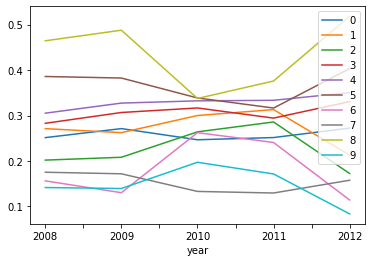

In [290]:
all_articles['year'] = all_articles['year'].astype(str)
all_articles.groupby(['year']) \
                  .mean() \
                  .plot();

### Move on to dynamic topic modelling

1. Obtain Time Slices
2. Stem words and create corpus
3. fit model
4. Save model
5. Visualise results

### Obtain time slices (do this even if you have a saved topic model to load)

In [8]:
# Get number of transcripts in each time slice
time_slice = all_articles.groupby('year')['contents'].count().to_list()

for i in range(len(time_slice)):
    print("Transcripts in Time Slice {}:".format(i), time_slice[i])

Transcripts in Time Slice 0: 230
Transcripts in Time Slice 1: 140
Transcripts in Time Slice 2: 842
Transcripts in Time Slice 3: 643
Transcripts in Time Slice 4: 45


### Stem Words and create corpus (do this even if you have a saved topic model to load)

In [9]:
stemmed_tokens = tokenize_infowars(all_articles['contents'])
dictionary, bow_corpus = prepare_data(stemmed_tokens)

### Fit model

In [180]:
# fit model
infowars_dtm = LdaSeqModel(bow_corpus,
                     time_slice,
                     id2word=dictionary,
                     num_topics=10)

C:\Users\thiya\AppData\Roaming\Python\Python37\site-packages\gensim\models\ldaseqmodel.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
C:\Users\thiya\AppData\Roaming\Python\Python37\site-packages\gensim\models\ldaseqmodel.py:297: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)
C:\Users\thiya\AppData\Roaming\Python\Python37\site-packages\gensim\models\ldaseqmodel.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
C:\Users\thiya\AppData\Roaming\Python\Python37\site-packages\gensim\models\ldaseqmodel.py:1478: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
C:\Users\thiya\AppData\Roaming\Python\Python37\site-packages\gensim\models\ldaseqmodel.py:1478: RuntimeWarning: invalid valu

### save/load from model file to save time on model fitting, 
#### you must have stemmed the tokens and created the corpus manually first

In [10]:
# save it as 'dtm.model' included in folder
# ldaseq.save('dtm.model')
infowars_dtm = models.LdaModel.load('topic_models/dtm.model')

### Visualise results

In [283]:
coherence = dtm_coherence([infowars_dtm],
                              bow_corpus,
                              dictionary,
                              n_time_slices=len(time_slice))

# Can check coherence for each model at each time slice
for i, score in enumerate(coherence[0]):
    print("Coherence at Time Slice {}:".format(i), score)

# As well as compute averages for overall comparison of models
print("Average Coherence: ", 
      sum(coherence[0]) / len(coherence[0]))

print_dtm(infowars_dtm, n_topics=10, n_time_slices=5)

Coherence at Time Slice 0: -0.8431286782776221
Coherence at Time Slice 1: -0.8600570250023427
Coherence at Time Slice 2: -0.8865567447098648
Coherence at Time Slice 3: -0.8836514962212074
Coherence at Time Slice 4: -0.8980958742220426
Average Coherence:  -0.8742979636866159
##### Topic 0, Time Slice 0 #####
['us', 'make', 'good', 'government', 'media', 'world', 'new', 'tell', 'anyone', 'party']
##### Topic 0, Time Slice 1 #####
['us', 'make', 'good', 'government', 'media', 'world', 'new', 'tell', 'anyone', 'party']
##### Topic 0, Time Slice 2 #####
['us', 'make', 'good', 'government', 'media', 'world', 'new', 'tell', 'party', 'anyone']
##### Topic 0, Time Slice 3 #####
['us', 'good', 'government', 'make', 'media', 'world', 'new', 'tell', 'party', 'well']
##### Topic 0, Time Slice 4 #####
['us', 'good', 'government', 'make', 'media', 'world', 'new', 'tell', 'border', 'party']


##### Topic 1, Time Slice 0 #####
['tsa', 'security', 'us', 'body', 'government', 'scanners', 'airport', 'make

In [11]:
pyLDAvis.enable_notebook()

# Create pyLDAvis visualization for each year:
vis = {}
dates = pd.Series(['2008', '2009', '2010', '2011', '2012'])
for i in range(5):
    doc_topic, topic_term, doc_lengths, term_frequency, vocab = infowars_dtm.dtm_vis(time=i, corpus=bow_corpus)
    vis[dates[i]] = pyLDAvis.prepare(topic_term_dists=topic_term,
                                            doc_topic_dists=doc_topic,
                                            doc_lengths=doc_lengths,
                                            vocab=vocab,
                                            term_frequency=term_frequency)

# Make an interactive plot so we can cycle through topics by year:
@interact(Year=dates)
def f(Year):
    return vis[Year]

C:\Users\thiya\AppData\Roaming\Python\Python37\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\ProgramData\Anaconda3\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\ProgramData\Anaconda3\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\ProgramData\Anaconda3\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\ProgramData\Anaconda3\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.fil

interactive(children=(Dropdown(description='Year', options=('2008', '2009', '2010', '2011', '2012'), value='20…

### Save visuals

In [285]:
# optionally save
for i in range(len(time_slice)):
    pyLDAvis.save_html(vis[dates[i]], 'infowars_t{}.html'.format(i))

### Repeat same process for subset of articles

In [12]:
articles_subset = all_articles[0::10]

In [189]:
articles_subset

,0,1,2,3,4,5,6,7,8,9,contents,tokens,year
0,0.312531,0.000000,0.000000,0.319760,0.359616,0.403206,0.000000,0.626835,0.354930,0.000000,A d v e r t i s e m e n tshow_banners();Are yo...,"[tshow, banners, ready, next, tuesday, cnn, el...",2008
10,0.000000,0.351994,0.279603,0.574679,0.614760,0.115030,0.031976,0.171028,0.401373,0.144173,Panelists with the Stop Real ID Coalition are ...,"[panelists, stop, id, coalition, calling, repe...",2008
20,0.341401,0.369421,0.019840,0.174312,0.520172,0.118471,0.000000,0.879862,0.375037,0.044635,Foreign \t\tPolicy Journal has learned that ...,"[foreign, policy, journal, learned, senior, ex...",2008
30,0.000000,0.000000,0.325036,0.209491,0.478848,0.303548,0.779937,0.988283,0.000000,0.000000,Residents in Newcastle who complain that drive...,"[residents, newcastle, complain, drivers, spee...",2008
40,0.000000,0.000000,0.124498,0.334718,0.132082,0.042623,0.859817,0.271039,0.000000,0.678512,The American surveillance society is one of th...,"[surveillance, society, worst, according, priv...",2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,0.203010,0.815400,0.250812,0.184512,0.165477,0.631455,0.749107,0.000000,0.995726,0.000000,Despite calls for the inclusion of Pneumococca...,"[despite, calls, inclusion, pneumococcal, conj...",2011
5,0.038559,0.000000,0.423679,0.120795,0.415161,0.830597,0.081020,0.000000,0.085430,0.000000,"On Tuesday, the Florida State Supreme Court wa...","[tuesday, florida, state, supreme, court, aske...",2012
15,0.000000,0.151105,0.125155,0.407359,0.230874,0.239387,0.595110,0.000000,0.162971,0.112577,Did you watch the presidential debate on Wedne...,"[presidential, debate, wednesday, night, absol...",2012
25,0.904694,0.239021,0.440334,0.206984,0.243580,0.075475,0.455903,0.334535,0.694761,0.000000,Instead of paying for their lunches with crump...,"[instead, paying, lunches, crumpled, dollar, b...",2012


In [13]:
time_slice = articles_subset.groupby('year')['contents'].count().to_list()

for i in range(len(time_slice)):
    print("Transcripts in Time Slice {}:".format(i), time_slice[i])

stemmed_tokens = tokenize_infowars(articles_subset['contents'])
dictionary, bow_corpus = prepare_data(stemmed_tokens)

Transcripts in Time Slice 0: 23
Transcripts in Time Slice 1: 14
Transcripts in Time Slice 2: 85
Transcripts in Time Slice 3: 64
Transcripts in Time Slice 4: 4


### Load model instead of fitting it, 
#### you must restem the tokens and recreate time slices as done in the line before this

In [14]:
# save it as 'dtm.subsetmodel' included in folder
# ldaseq.save('dtm.subsetmodel')
infowars_subset_dtm = models.LdaModel.load('topic_models/dtm.subsetmodel')

### Or you can fit it

In [ ]:
infowars_subset_dtm = LdaSeqModel(bow_corpus,
                     time_slice,
                     id2word=dictionary,
                     num_topics=5)

In [15]:
pyLDAvis.enable_notebook()

# Create pyLDAvis visualization for each year:
vis = {}
dates = pd.Series(['2008', '2009', '2010', '2011', '2012'])
for i in range(5):
    doc_topic, topic_term, doc_lengths, term_frequency, vocab = infowars_subset_dtm.dtm_vis(time=i, corpus=bow_corpus)
    vis[dates[i]] = pyLDAvis.prepare(topic_term_dists=topic_term,
                                            doc_topic_dists=doc_topic,
                                            doc_lengths=doc_lengths,
                                            vocab=vocab,
                                            term_frequency=term_frequency)

# Make an interactive plot so we can cycle through topics by year:
@interact(Year=dates)
def f(Year):
    return vis[Year]



C:\Users\thiya\AppData\Roaming\Python\Python37\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
C:\ProgramData\Anaconda3\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\ProgramData\Anaconda3\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\ProgramData\Anaconda3\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\ProgramData\Anaconda3\lib\site-packages\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.fil

interactive(children=(Dropdown(description='Year', options=('2008', '2009', '2010', '2011', '2012'), value='20…

## Save visuals

In [291]:
# optionally save
for i in range(len(time_slice)):
    pyLDAvis.save_html(vis[dates[i]], 'infowars_subset{}.html'.format(i))

The use of 5 topics on the subset of articles yields more coherent results, hence for future iterations 5 topics might be a better parameter for the dynamic topic model